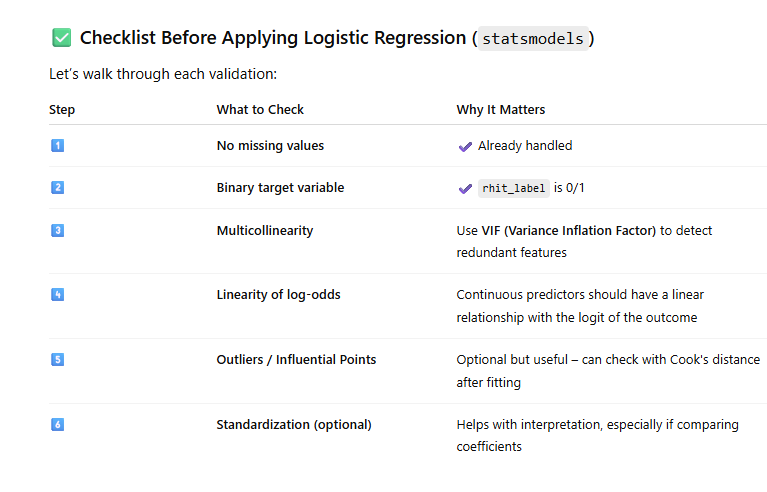

In [11]:
import pandas as pd
import numpy as np

df_cleaned = pd.read_csv(r'Paccar Cleaned Data - Selected_Features.csv')
df_cleaned = df_cleaned.drop(df_cleaned.columns[0], axis=1)        

In [12]:
df_cleaned

,rhit_within_2wks,oo_dos,doh_less_ss,days_below_ss,no_ship_ratio,ltm_90pct,ltm_75pct,ltm_median,ltm_90pct_difference_wks,mdi_stockouts,ots_pct,ss_units_left_pct,dmd_wkly_dos,doh_to_ltm,days_on_hand,rhit_label
0,0,35.793116,0,0,0.000000,34.0,32.00,30.0,4.0,1.0,0.480769,1.073793,10.243902,0.785703,32.213804,0
1,0,57.213895,1,30,0.000000,30.0,29.75,29.0,1.0,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0
2,0,22.815134,1,2,0.600000,57.7,43.75,34.0,23.7,0.0,0.523810,0.760504,8.235294,1.425946,34.222701,0
3,0,21.536768,1,0,0.000000,44.8,42.25,39.0,5.8,0.0,0.769231,1.133514,10.500000,0.783155,43.073536,0
4,0,21.536768,1,1,0.000000,44.8,42.25,39.0,5.8,0.0,0.769231,1.133514,10.500000,0.783155,43.073536,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143361,0,30.542986,1,0,0.047619,17.5,16.00,15.0,2.5,2.0,0.411194,0.442652,7.000000,0.848416,20.361991,0
143362,0,0.000000,0,23,1.000000,36.0,36.00,36.0,0.0,0.0,0.000000,1.450262,10.500000,1.891646,43.507862,1
143363,1,73.261067,1,30,1.000000,36.0,36.00,36.0,0.0,0.0,0.000000,-0.814012,-7.000000,-1.061755,-24.420356,0
143364,0,0.000000,0,30,1.000000,75.1,69.25,57.0,18.1,1.0,0.250000,1.257457,10.500000,1.640162,37.723723,0


In [16]:
import pandas as pd
import numpy as np
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Step 1: Prepare feature matrix X and target y
features = [
    'rhit_within_2wks', 'oo_dos', 'doh_less_ss', 'days_below_ss', 'no_ship_ratio',
    'ltm_90pct', 'ltm_75pct', 'ltm_median', 'ltm_90pct_difference_wks', 'mdi_stockouts',
    'ots_pct', 'ss_units_left_pct', 'dmd_wkly_dos', 'doh_to_ltm', 'days_on_hand'
]
X = df_cleaned[features]
y = df_cleaned['rhit_label']

# Step 2: Add constant for VIF calculation
X_const = add_constant(X)

# Step 3: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif_data

C:\Users\sansk\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,const,15.365420
1,rhit_within_2wks,1.531100
2,oo_dos,2.041245
3,doh_less_ss,1.887830
4,days_below_ss,1.746553
5,no_ship_ratio,1.844242
6,ltm_90pct,inf
7,ltm_75pct,63.221339
8,ltm_median,inf
9,ltm_90pct_difference_wks,inf


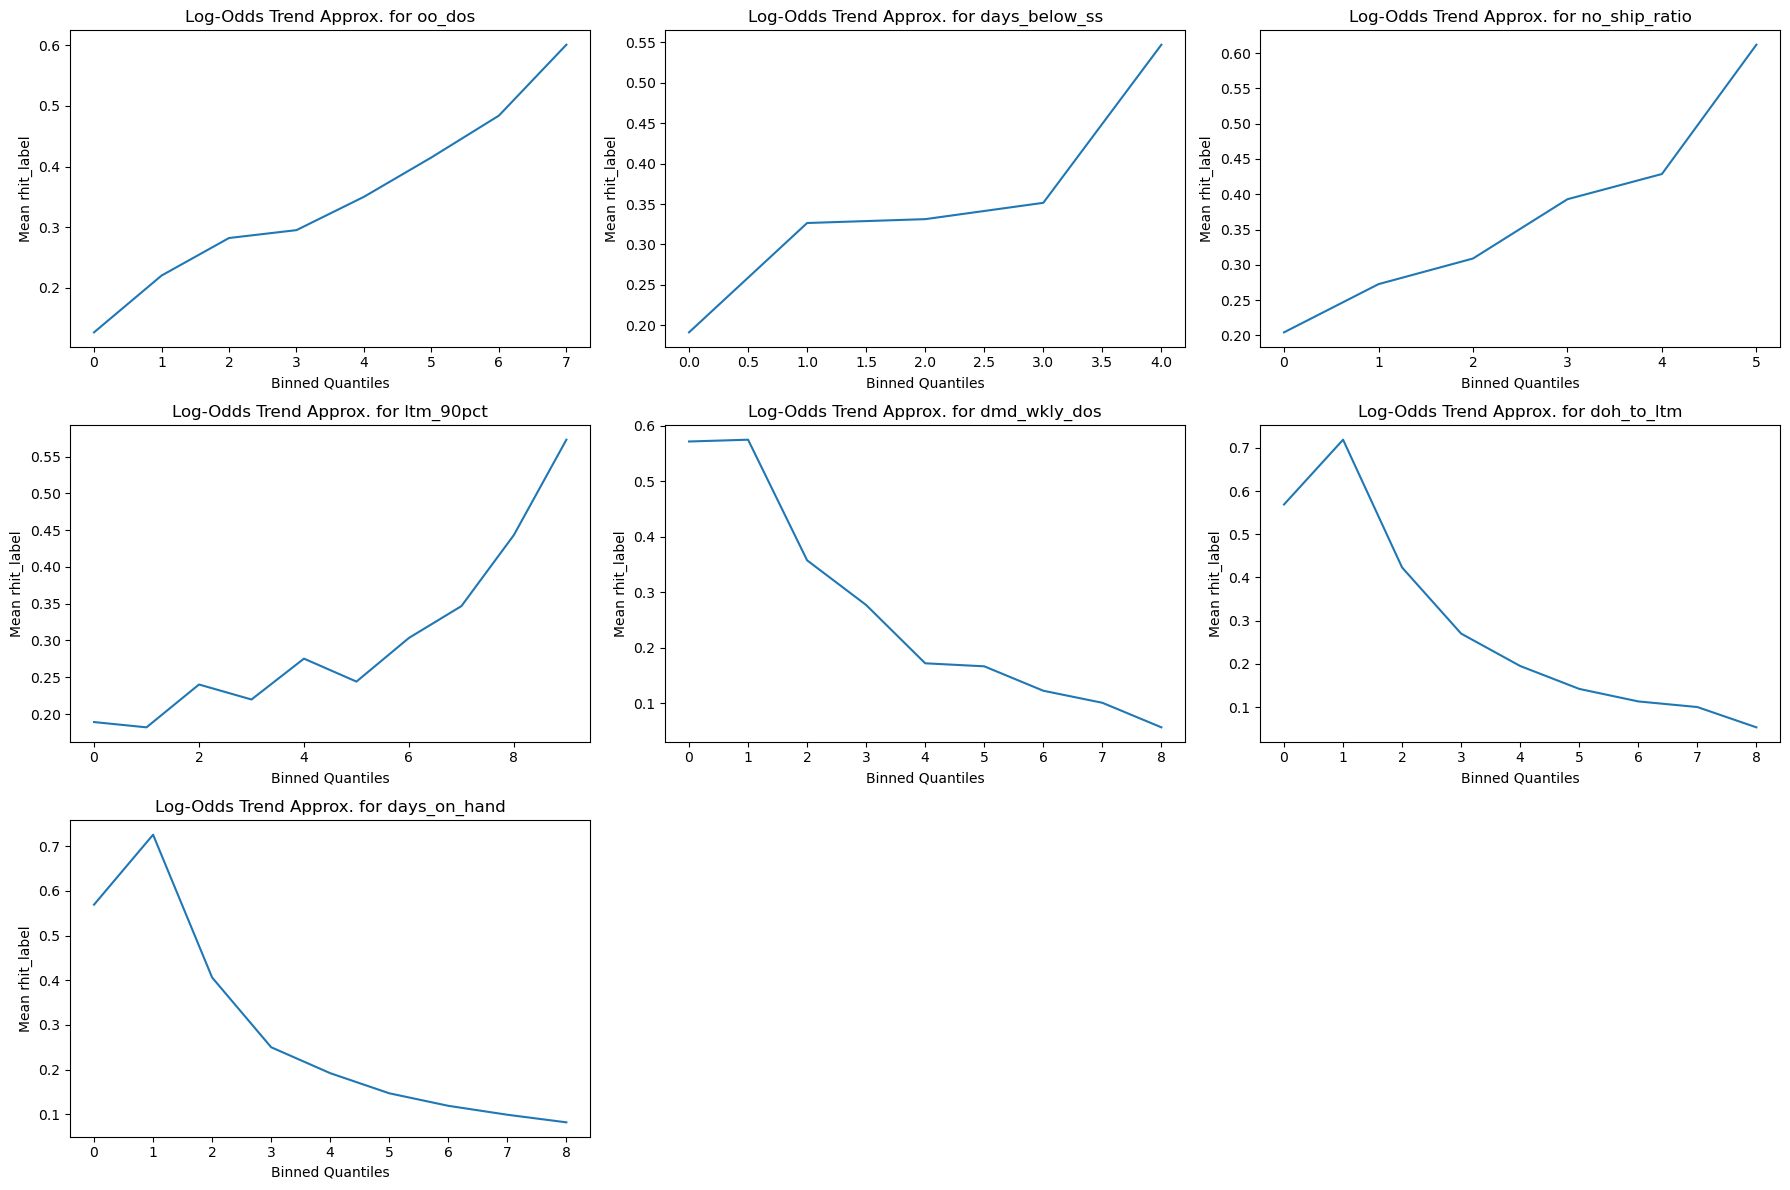

In [13]:
# Visual check for linearity of log-odds using binned average plot
import matplotlib.pyplot as plt
import seaborn as sns

# Copy to avoid modifying original data
temp_df = df_cleaned.copy()

# Sample a subset for visualization speed
temp_df_sample = temp_df.sample(10000, random_state=42)

# Bin continuous variables and plot average rhit_label
continuous_vars = [
    'oo_dos', 'days_below_ss', 'no_ship_ratio', 'ltm_90pct', 'dmd_wkly_dos', 'doh_to_ltm', 'days_on_hand'
]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(continuous_vars):
    temp_df_sample['bin'] = pd.qcut(temp_df_sample[col], q=10, duplicates='drop')
    binned = temp_df_sample.groupby('bin')['rhit_label'].mean().reset_index()
    sns.lineplot(x=binned.index, y=binned['rhit_label'], ax=axes[i])
    axes[i].set_title(f'Log-Odds Trend Approx. for {col}')
    axes[i].set_xlabel("Binned Quantiles")
    axes[i].set_ylabel("Mean rhit_label")

# Hide any unused subplots
for j in range(len(continuous_vars), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


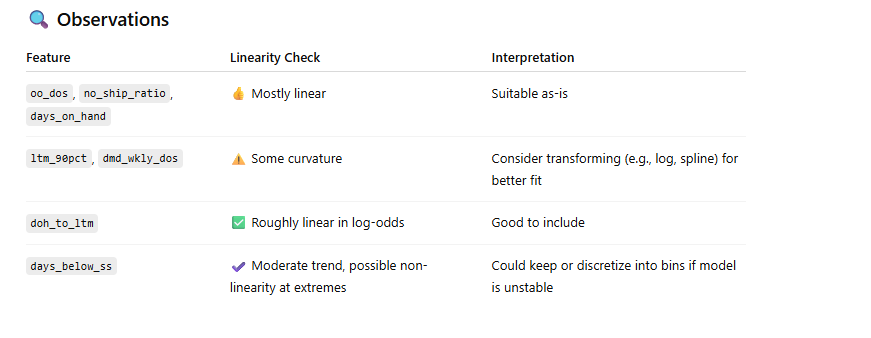

## Applying the models now

## Model 1 - with rhit within 2 weeks

In [28]:
import statsmodels.api as sm

# Add constant term for intercept
X_with_const = sm.add_constant(X)

# Fit logistic regression model
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()

# Summarize results
summary = result.summary2().tables[1]
summary

Optimization terminated successfully.
         Current function value: 0.473519
         Iterations 26


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-0.869912,0.028408,-30.621979,6.241095e-206,-0.925591,-0.814233
rhit_within_2wks,0.752680,0.020065,37.511484,5.985526e-308,0.713353,0.792007
oo_dos,0.000979,0.000232,4.213681,2.512416e-05,0.000524,0.001435
doh_less_ss,0.385690,0.020016,19.269475,9.691397e-83,0.346460,0.424920
days_below_ss,-0.001274,0.000713,-1.787174,7.390930e-02,-0.002671,0.000123
no_ship_ratio,0.191158,0.027197,7.028590,2.086314e-12,0.137853,0.244464
ltm_90pct,0.005641,NaN,NaN,NaN,NaN,NaN
ltm_75pct,-0.003418,0.001484,-2.303270,2.126368e-02,-0.006326,-0.000509
ltm_median,0.005330,NaN,NaN,NaN,NaN,NaN
ltm_90pct_difference_wks,0.000050,NaN,NaN,NaN,NaN,NaN


In [19]:
# Also show classification performance metrics
y_pred_prob = result.predict(X_with_const)
y_pred_class = (y_pred_prob >= 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

report = classification_report(y, y_pred_class, output_dict=True)
report

{'0': {'precision': 0.7881461392562586,
  'recall': 0.9216857191605528,
  'f1-score': 0.8497011417679824,
  'support': 99637.0},
 '1': {'precision': 0.709353000335233,
  'recall': 0.4355004687964509,
  'f1-score': 0.5396735434141917,
  'support': 43729.0},
 'accuracy': 0.7733911806146506,
 'macro avg': {'precision': 0.7487495697957458,
  'recall': 0.6785930939785019,
  'f1-score': 0.6946873425910871,
  'support': 143366.0},
 'weighted avg': {'precision': 0.7641129293468134,
  'recall': 0.7733911806146506,
  'f1-score': 0.7551375991678337,
  'support': 143366.0}}

In [20]:
conf_matrix = confusion_matrix(y, y_pred_class)
roc_auc = roc_auc_score(y, y_pred_prob)

report_df = pd.DataFrame(report).transpose()
report_df["roc_auc_score"] = roc_auc if "accuracy" in report_df.index else None

In [21]:
conf_matrix

array([[91834,  7803],
       [24685, 19044]], dtype=int64)

In [23]:
report_df

,precision,recall,f1-score,support,roc_auc_score
0,0.788146,0.921686,0.849701,99637.000000,0.815072
1,0.709353,0.435500,0.539674,43729.000000,0.815072
accuracy,0.773391,0.773391,0.773391,0.773391,0.815072
macro avg,0.748750,0.678593,0.694687,143366.000000,0.815072
weighted avg,0.764113,0.773391,0.755138,143366.000000,0.815072


## Analysis

In [26]:
df_cleaned['rhit_label'].value_counts(normalize=True).rename_axis('rhit_label').reset_index(name='proportion')

,rhit_label,proportion
0,0,0.694983
1,1,0.305017


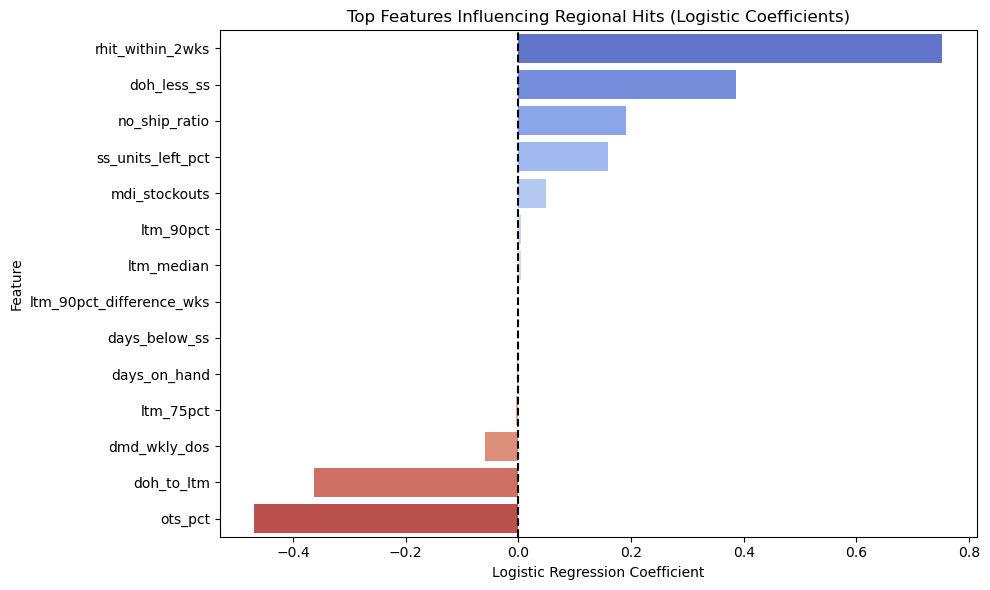

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Extract and sort significant coefficients (exclude constant)
coef_table = result.summary2().tables[1].copy()
coef_table = coef_table.drop(index='const')
coef_table = coef_table.sort_values(by='Coef.', ascending=False)

# Plot top positive and negative coefficients
top_n = 7
top_pos = coef_table.head(top_n)
top_neg = coef_table.tail(top_n)

# Concatenate for plotting
top_features = pd.concat([top_pos, top_neg])
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features['Coef.'], y=top_features.index, palette='coolwarm')
plt.axvline(0, color='black', linestyle='--')
plt.title('Top Features Influencing Regional Hits (Logistic Coefficients)')
plt.xlabel('Logistic Regression Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


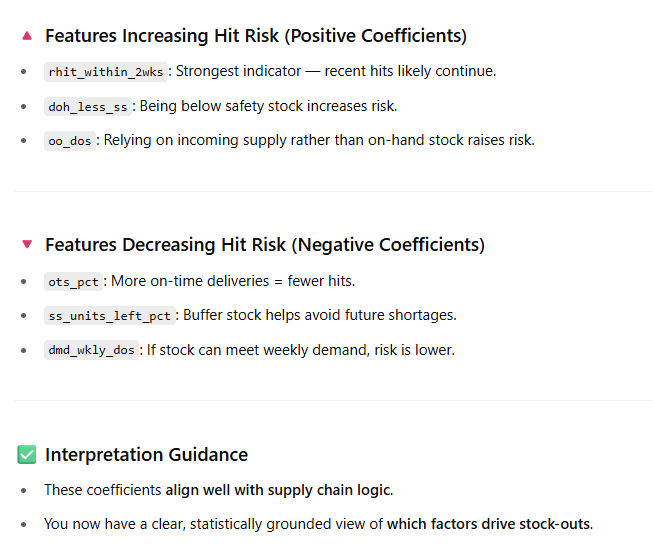

## Model 2 - With Sklearn's regularization

In [30]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Step 1: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Fit L2-Regularized Logistic Regression with cross-validation
logreg_cv = LogisticRegressionCV(cv=5, penalty='l2', solver='liblinear', scoring='f1', max_iter=1000)
logreg_cv.fit(X_train_scaled, y_train)

# Step 4: Evaluate model
y_pred = logreg_cv.predict(X_test_scaled)
y_prob = logreg_cv.predict_proba(X_test_scaled)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

report_df = pd.DataFrame(report).transpose()
report_df["roc_auc_score"] = roc_auc if "accuracy" in report_df.index else None

# Feature importances from coefficients
feature_importance = pd.Series(logreg_cv.coef_[0], index=X.columns).sort_values()



In [31]:
report_df

,precision,recall,f1-score,support,roc_auc_score
0,0.797458,0.892696,0.842394,19962.000000,0.806143
1,0.661504,0.480487,0.556649,8712.000000,0.806143
accuracy,0.767455,0.767455,0.767455,0.767455,0.806143
macro avg,0.729481,0.686591,0.699521,28674.000000,0.806143
weighted avg,0.756151,0.767455,0.755576,28674.000000,0.806143


In [32]:
conf_matrix

array([[17820,  2142],
       [ 4526,  4186]], dtype=int64)

In [33]:
feature_importance.to_frame("Coefficient")

,Coefficient
dmd_wkly_dos,-0.264944
doh_to_ltm,-0.193157
days_on_hand,-0.179096
ots_pct,-0.094973
ss_units_left_pct,0.007562
ltm_90pct_difference_wks,0.028317
days_below_ss,0.053754
ltm_75pct,0.073910
oo_dos,0.076961
ltm_90pct,0.077464


## Tried adjusting the thresholds to see if we are able to trade-off well?

In [37]:
from sklearn.metrics import recall_score,precision_score

# Narrow the threshold range between 0.55 and 0.65
thresholds = np.arange(0.55, 0.66, 0.01)
precision_scores = []
recall_scores = []
accuracy_scores = []

for thresh in thresholds:
    preds = (y_prob >= thresh).astype(int)
    precision_scores.append(precision_score(y_test, preds))
    recall_scores.append(recall_score(y_test, preds))
    accuracy_scores.append((y_test == preds).mean())

# Create a DataFrame to display
threshold_df_narrow = pd.DataFrame({
    "Threshold": thresholds,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "Accuracy": accuracy_scores
})


threshold_df_narrow.sort_values(by="Precision", ascending=False)


,Threshold,Precision,Recall,Accuracy
10,0.65,0.765839,0.269169,0.752947
9,0.64,0.760856,0.281566,0.754830
8,0.63,0.754127,0.293618,0.756295
7,0.62,0.745043,0.306244,0.757376
6,0.61,0.737836,0.318526,0.758562
5,0.60,0.730613,0.330923,0.759643
4,0.59,0.727711,0.346648,0.762084
3,0.58,0.720467,0.361226,0.763340
2,0.57,0.716866,0.378099,0.765676
1,0.56,0.706708,0.393021,0.766025


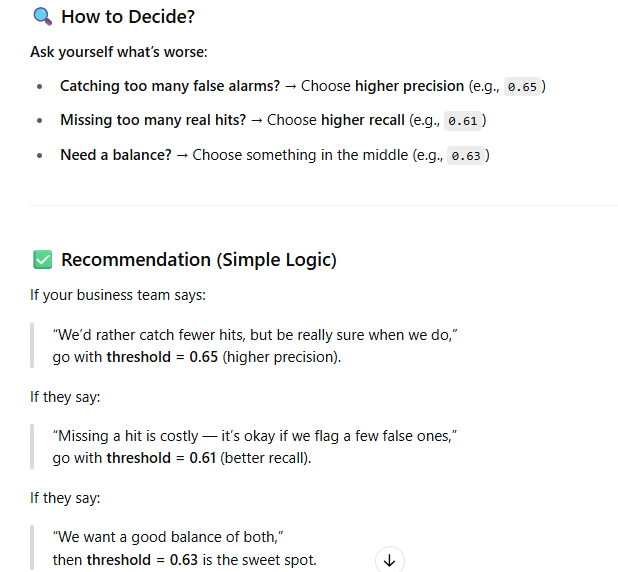